# 一般的なDenseAffeneでのCNNのバイナリ化実験(CIFAR-10学習)

DenseAffene モデルで畳み込み層を形成して、Binarize 層を入れて実験を行います。 

In [21]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torchvision
import torchvision.transforms as transforms

import binarybrain as bb

### データセット

データセットの準備には torchvision を使います

In [22]:
# configuration
base_name             = 'Cifar10DenseCnn'
data_path             = './data/'
result_file           = os.path.join(data_path, base_name + '_result.pickle')
epochs                = 8
mini_batch_size       = 32

# dataset
dataset_path = './data/'
dataset_train = torchvision.datasets.CIFAR10(root=dataset_path, train=True, transform=transforms.ToTensor(), download=True)
dataset_test  = torchvision.datasets.CIFAR10(root=dataset_path, train=False, transform=transforms.ToTensor(), download=True)
loader_train = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=mini_batch_size, shuffle=True, num_workers=2)
loader_test  = torch.utils.data.DataLoader(dataset=dataset_test,  batch_size=mini_batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## パラメータを変えて学習実験する準備

In [23]:
# 叩き込み層生成
def make_conv_layer(output_shape, filter_size, bin_dtype):
    return bb.Convolution2d(
               bb.Sequential([
                   bb.DenseAffine(output_shape),
                   bb.BatchNormalization(),
                   bb.ReLU(bin_dtype=bin_dtype)
                ]),
                filter_size=filter_size,
                fw_dtype=bin_dtype)


# 学習実験
def learning(net_name, frame_modulation_size, depth_modulation_size=1, epochs=8, bin_mode=True):
    save_path = os.path.join(data_path, net_name)
    
    # バイナリ時は BIT型を使えばメモリ削減可能
    bin_dtype = bb.DType.BIT if bin_mode else bb.DType.FP32
    
    # define network
    net = bb.Sequential([
                make_conv_layer([32], filter_size=(3, 3), bin_dtype=bin_dtype),  # 32x32 -> 30x30
                make_conv_layer([64], filter_size=(3, 3), bin_dtype=bin_dtype),  # 30x30->28x28
                bb.MaxPooling(filter_size=(2, 2), fw_dtype=bin_dtype),           # 28x28-> 14x14
                make_conv_layer([64], filter_size=(3, 3), bin_dtype=bin_dtype),  # 14x14-> 12x12
                make_conv_layer([128], filter_size=(3, 3), bin_dtype=bin_dtype), # 12x12-> 10x10
                bb.MaxPooling(filter_size=(2, 2), fw_dtype=bin_dtype),           # 10x10-> 5x5
                make_conv_layer([512], filter_size=(5, 5), bin_dtype=bin_dtype), # 5x5-> 1x1
                make_conv_layer([10], filter_size=(1, 1), bin_dtype=bin_dtype),  # 5x5-> 1x1
            ])

    if bin_mode:
        net = bb.Sequential([
            bb.RealToBinary(frame_modulation_size=frame_modulation_size, depth_modulation_size=depth_modulation_size, bin_dtype=bin_dtype),
            net,
            bb.BinaryToReal(frame_integration_size=frame_modulation_size, bin_dtype=bin_dtype)
        ])

    net.set_input_shape([3, 32, 32])

    if bin_mode:
        net.send_command("binary true")

    # print(net.get_info()) # ネットを表示
    # learning
    loss      = bb.LossSoftmaxCrossEntropy()
    metrics   = bb.MetricsCategoricalAccuracy()
    optimizer = bb.OptimizerAdam()

    optimizer.set_variables(net.get_parameters(), net.get_gradients())
    
    train_loss = []
    train_acc  = []
    test_loss = []
    test_acc  = []
    
    with tqdm(range(epochs)) as t:
        for epoch in t:
            loss.clear()
            metrics.clear()
            
            # training
            for images, labels in loader_train:
                x_buf = bb.FrameBuffer.from_numpy(np.array(images).astype(np.float32))
                t_buf = bb.FrameBuffer.from_numpy(np.identity(10)[np.array(labels)].astype(np.float32))

                y_buf = net.forward(x_buf, train=True)

                dy_buf = loss.calculate(y_buf, t_buf)
                metrics.calculate(y_buf, t_buf)
                net.backward(dy_buf)

                optimizer.update()

            train_loss.append(loss.get())
            train_acc.append(metrics.get())

            # test
            loss.clear()
            metrics.clear()
            for images, labels in loader_test:
                x_buf = bb.FrameBuffer.from_numpy(np.array(images).astype(np.float32))
                t_buf = bb.FrameBuffer.from_numpy(np.identity(10)[np.array(labels)].astype(np.float32))

                y_buf = net.forward(x_buf, train=False)

                loss.calculate(y_buf, t_buf)
                metrics.calculate(y_buf, t_buf)

            test_loss.append(loss.get())
            test_acc.append(metrics.get())

            bb.save_networks(save_path, net)        
            t.set_postfix(loss=loss.get(), acc=metrics.get())
    
    return train_loss, train_acc, test_loss, test_acc

## 変調数を変えて学習実験を行う
Frame方向(Frame拡大)やDepth方向(チャネル拡大)にそれぞれ変調を掛けて結果を観察してみます。

In [24]:
learning_pattern = [
    {'net_name': 'real(no binary)', 'frame_modulation_size':1,  'epochs': epochs, 'bin_mode':False},
    {'net_name': 'frame=1',         'frame_modulation_size':1,  'epochs': epochs, 'bin_mode':True},
    {'net_name': 'frame=3',         'frame_modulation_size':3,  'epochs': epochs, 'bin_mode':True},
    {'net_name': 'frame=7',         'frame_modulation_size':7,  'epochs': epochs, 'bin_mode':True},
    {'net_name': 'frame=15',        'frame_modulation_size':15, 'epochs': epochs, 'bin_mode':True},
    {'net_name': 'depth=3',         'frame_modulation_size':3,  'epochs': epochs, 'bin_mode':True},
    {'net_name': 'depth=7',         'frame_modulation_size':7,  'epochs': epochs, 'bin_mode':True},
    {'net_name': 'depth=15',        'frame_modulation_size':15, 'epochs': epochs, 'bin_mode':True},
]

result_set = {}

# 前のものがあれば読み込む
if os.path.exists(result_file):
    with open(result_file, 'rb') as f:
        result_set = pickle.load(f)

for ptn in learning_pattern:
    if ptn['net_name'] not in result_set:
        # 学習実験
        print(ptn['net_name'])
        train_loss, train_loss, test_loss, test_acc = learning(**ptn)
        result_set[ptn['net_name']] = [train_loss, train_loss, test_loss, test_acc]

        # 保存
        with open(result_file, 'wb') as f:
            pickle.dump(result_set, f)

frame=1


  0%|          | 0/8 [00:00<?, ?it/s]

/tmp/ipykernel_27447/516491576.py:64: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  x_buf = bb.FrameBuffer.from_numpy(np.array(images).astype(np.float32))
/tmp/ipykernel_27447/516491576.py:65: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  t_buf = bb.FrameBuffer.from_numpy(np.identity(10)[np.array(labels)].astype(np.float32))


KeyboardInterrupt: 

FP32には及びませんが、少なからず単純バイナリネットの範疇ではこれらのバイナリ変調で入力拡張を行うと改善がみられることは観察でるようです。
まだまだ今後の研究課題です。

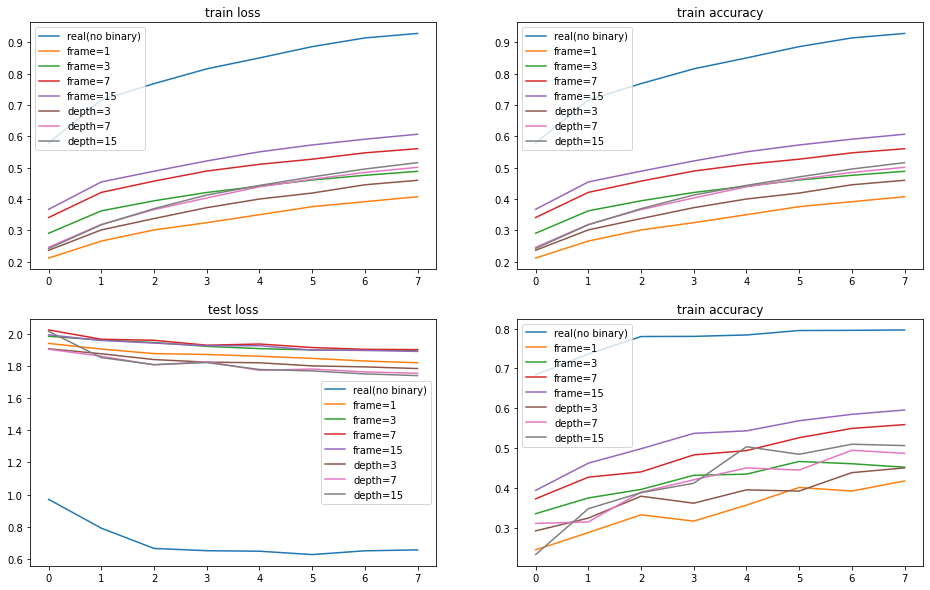

In [ ]:
plt.figure(figsize=(16, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.title(['train loss', 'train accuracy', 'test loss', 'train accuracy'][i])
    for name in result_set:
        plt.plot(result_set[name][i], label=name)
    plt.legend()
plt.show()